In [1]:
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

import matplotlib.pyplot as plt
import torch.optim as optim

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [2]:
cd /home/ehaber/PfoldNew

/home/ehaber/PfoldNew


In [3]:
from src import networks
from src import pnetProcess
from src import utils

In [4]:
ls ../data/casp11

AminoAcidIdx.pt         entropyTesting.pt  MasksVal.pt     RCalpha.pt
AminoAcidIdxTesting.pt  entropyVal.pt      PSSM.pt         RCalphaTesting.pt
AminoAcidIdxVal.pt      Masks.pt           PSSMTesting.pt  RCalphaVal.pt
entropy.pt              MasksTesting.pt    PSSMVal.pt


In [5]:
# load training data
Aind = torch.load('../data/casp11/AminoAcidIdx.pt')
Yobs = torch.load('../data/casp11/RCalpha.pt')
MSK  = torch.load('../data/casp11/Masks.pt')
S     = torch.load('../data/casp11/PSSM.pt')
# load validation data
AindVal = torch.load('../data/casp11/AminoAcidIdxVal.pt')
YobsVal = torch.load('../data/casp11/RCalphaVal.pt')
MSKVal  = torch.load('../data/casp11/MasksVal.pt')
SVal     = torch.load('../data/casp11/PSSMVal.pt')

# load Testing data
AindTesting = torch.load('../data/casp11/AminoAcidIdxTesting.pt')
YobsTesting = torch.load('../data/casp11/RCalphaTesting.pt')
MSKTesting  = torch.load('../data/casp11/MasksTesting.pt')
STesting     = torch.load('../data/casp11/PSSMTesting.pt')


print('Number of data: ', len(S))
n_data_total = len(S)

Number of data:  42338


In [6]:
def getIterData(S,Aind,Yobs,MSK,i,device='cpu'):
    
    scale = 1e-3
    PSSM = S[i].t()
    n = PSSM.shape[1]
    M = MSK[i][:n]
    a = Aind[i]
    
    #X = Yobs[i][0, 0, :n, :n]
    X = Yobs[i].t()
    X = utils.linearInterp1D(X,M)
    X = torch.tensor(X)

    X = X - torch.mean(X,dim=1, keepdim=True)
    U, Lam, V = torch.svd(X)

    Coords = scale*torch.diag(Lam)@V.t()
    Coords = Coords.type('torch.FloatTensor')

    PSSM    = PSSM.type(torch.float32)
    PSSM    = augmentPSSM(PSSM, 0.05) 
    
    A = torch.zeros(20,n)
    A[a, torch.arange(0,n)] = 1.0
    Seq = torch.cat((PSSM,A))
    #Seq = torch.cat((A,-A))
    
    Seq = Seq.to(device=device, non_blocking=True)
    
    Coords = Coords.to(device=device, non_blocking=True)
    M      = M.type('torch.FloatTensor')
    M      = M.to(device=device, non_blocking=True)

    return Seq, Coords, M

def augmentPSSM(Z, sig=1):
    Uz, Laz, Vz = torch.svd(Z)
    n = len(Laz)
    r = torch.rand(n)*Laz.max()*sig
    Zout = Uz@torch.diag((1+r)*Laz)@Vz.t()
    Zout = torch.relu(Zout)
    Zout = Zout/(torch.sum(Zout,dim=0,keepdim=True) + 0.001)
    return Zout

device(type='cpu')

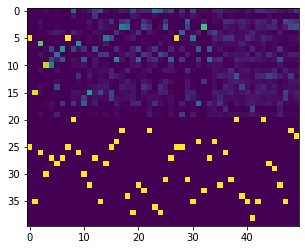

In [7]:
Z,C,M = getIterData(S,Aind,Yobs,MSK,10)
plt.imshow(Z[:,:50])
Z.device

torch.Size([40, 203])
torch.Size([3, 203])
torch.Size([203])


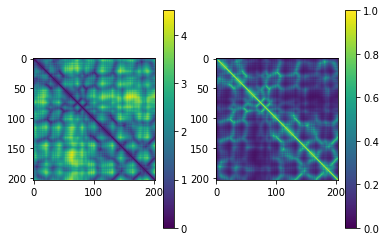

In [10]:
Seq, Coords, M = getIterData(S,Aind,Yobs,MSK,11)
print(Seq.shape)
print(Coords.shape)
print(M.shape)

MM = torch.ger(M,M)
DMt = utils.getDistMat(Coords)
dm  = DMt.max()
sig = 0.3
D   = torch.exp(-DMt/(dm*sig))
plt.subplot(1,2,1)
plt.imshow(MM*DMt)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(MM*D)
plt.colorbar()

In [15]:
nstart  = 3
nopen   = 128
nhid    = 256
nclose  = 40
nlayers = 50
h       = 1/nlayers
Arch = [nstart, nopen, nhid, nclose, nlayers]

#model = networks.graphNN(Arch)
model = networks.hyperNet(Arch,h)
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters ',total_params)



Initializing network  
Number of parameters  29509504


In [16]:

lrO = 1e-2 #1e-4
lrC = 1e-2 #1e-3
lrN = 1e-2 #1e-4
lrB = 1e-2 #1e-4

optimizer = optim.Adam([{'params': model.Kopen, 'lr': lrO},
                        {'params': model.Kclose, 'lr': lrC},
                        {'params': model.W, 'lr': lrN},
                        {'params': model.Bias, 'lr': lrB}])

#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2)

alossBest = 1e6
ndata = len(S)
epochs = 30
sig   = 0.3
ndata = n_data_total
bestModel = model
hist = torch.zeros(epochs)

In [ ]:
print('         Design       Coords      Reg           gradW       gradKo        gradKc       gradB')
for j in range(epochs):
    # Prepare the data
    aloss = 0.0
    amis  = 0.0
    amisb = 0.0
    for i in range(ndata):

        Z, Coords, M = getIterData(S, Aind, Yobs, MSK, i, device=device)
        M = torch.ger(M,M)

        optimizer.zero_grad()
        # From Coords to Seq
        Zout, Zold = model(Coords)
        PSSMpred = F.softshrink(Zout[:20,:].abs(), Zout.abs().mean().item()/5)
        misfit = utils.kl_div(PSSMpred, Z[:20,:],weight=True)
        
        # From Seq to Coord
        Cout, CoutOld  = model.backwardProp(Z)
        d = torch.sqrt(torch.sum((Coords[:,1:] - Coords[:,:-1])**2,dim=0)).mean()
        Cout    = utils.distConstraint(Cout,d)
        CoutOld = utils.distConstraint(CoutOld, d)

        DM  = utils.getDistMat(Cout)
        DMt = utils.getDistMat(Coords)
        dm  = DMt.max()
        D   = torch.exp(-DM/(dm*sig))
        Dt  = torch.exp(-DMt/(dm*sig))
        misfitBackward = torch.norm(M*Dt-M*D)**2/torch.norm(M*Dt)**2
        #W = 1/(DMt+1e-4*torch.ones(DMt.shape[0], device=device))
        misfitBackward = torch.norm((M*Dt-M*D))**2/torch.norm((M*Dt))**2
        
        R    = model.NNreg()
        C0   = torch.norm(Cout - CoutOld)**2/torch.numel(Z)
        Z0   = torch.norm(Zout-Zold)**2/torch.numel(Z)
        loss = misfit + misfitBackward + R + C0 + Z0

        loss.backward(retain_graph=True)

        aloss += loss.detach()
        amis  += misfit.detach().item()
        amisb += misfitBackward.detach().item()
        
        optimizer.step()
        #scheduler.step()
        nprnt = 1000
        if (i+1)%nprnt==0:
            amis  = amis/nprnt
            amisb = amisb/nprnt
            print("%2d.%1d   %10.3E   %10.3E   %10.3E   %10.3E   %10.3E   %10.3E   %10.3E" %
                    (j,i,amis, amisb, R.item(),
                    model.W.grad.norm().item(),model.Kopen.grad.norm().item(),model.Kclose.grad.norm().item(),
                    model.Bias.grad.norm().item()))
            amis  = 0.0
            amisb = 0.0
    if aloss < alossBest:
        alossBest = aloss
        bestModel = model

    # Validation on 0-th data
    with torch.no_grad():
        misVal  = 0
        misbVal = 0
        AQdis   = 0
        #nVal    = len(SVal)
        nVal    = len(STesting)
        for jj in range(nVal):
            #Z, Coords, M = getIterData(SVal, AindVal, YobsVal, MSKVal, jj,device=device)
            Z, Coords, M = getIterData(STesting, AindTesting, YobsTesting, MSKTesting, jj,device=device)
            M = torch.ger(M,M)
            Zout, Zold = model(Coords)
            PSSMpred   = F.softshrink(Zout[:20,:].abs(), Zout.abs().mean().item()/5)
            misfit     = utils.kl_div(PSSMpred, Z[:20,:],weight=True)
            
            misVal += misfit
            # From Seq to Coord
            Cout, CoutOld  = model.backwardProp(Z)
            d = torch.sqrt(torch.sum((Coords[:,1:] - Coords[:,:-1])**2,dim=0)).mean()
            Cout    = utils.distConstraint(Cout,d)
            CoutOld = utils.distConstraint(CoutOld, d)

            DM  = utils.getDistMat(Cout)
            DMt = utils.getDistMat(Coords)
            dm  = DMt.max()
            D   = torch.exp(-DM/(dm*sig))
            Dt  = torch.exp(-DMt/(dm*sig))
            #misfitBackward = torch.norm(M*DMt-M*DM)**2/torch.norm(M*DMt)**2
            #W = 1/(DMt+1e-4*torch.ones(DMt.shape[0], device=device))
            misfitBackward = torch.norm((M*Dt-M*D))**2/torch.norm((M*Dt))**2


            misbVal += misfitBackward
            AQdis += torch.norm(M*(DM-DMt))/M.shape[0]/(M.shape[1]-1)
        
        print("%2d       %10.3E   %10.3E   %10.3E" %(j,misVal/nVal, misbVal/nVal, AQdis/nVal))
        print('===============================================')    


    hist[j] = (aloss).item()/(ndata)



         Design       Coords      Reg           gradW       gradKo        gradKc       gradB
 0.999    1.091E+00    3.532E-01    9.549E-02    7.505E-02    2.725E-01    2.105E+00    3.365E-03
 0.1999    1.048E+00    3.050E-01    9.830E-02    1.212E-01    5.637E-01    3.299E+00    3.443E-02
 0.2999    1.087E+00    3.003E-01    1.187E-01    2.945E-02    1.444E-01    1.704E+00    6.611E-03
 0.3999    1.803E+00    3.307E-01    2.538E-01    3.671E-02    4.094E-01    9.678E-01    9.745E-03
 0.4999    1.089E+00    2.817E-01    2.138E-01    1.436E-02    2.672E-01    5.363E-01    3.451E-03
 0.5999    1.080E+00    2.665E-01    2.123E-01    4.770E-02    8.707E-01    2.546E+00    8.743E-03
 0.6999    1.055E+00    2.339E-01    1.958E-01    4.133E-02    7.099E-01    1.500E+00    7.400E-03
 0.7999    1.165E+00    2.276E-01    1.939E-01    1.790E-02    2.735E-01    5.700E-01    3.712E-03
 0.8999    1.208E+00    2.227E-01    1.937E-01    4.188E-02    8.476E-01    7.739E-01    9.949E-03
 0.9999    1.845E

0.07051231861114501

In [12]:
    with torch.no_grad():
        misVal  = 0
        misbVal = 0
        AQdis   = 0
        TrueD = []
        RecD  = []
        MM    = []
        nVal    = len(STesting)
        for jj in range(nVal):
            Z, Coords, M = getIterData(STesting, AindTesting, YobsTesting, MSKTesting, jj,device=device)
            M = torch.ger(M,M)
            Zout, Zold = model(Coords)
            PSSMpred   = F.softshrink(Zout[:20,:].abs(), Zout.abs().mean().item()/5)
            misfit = utils.kl_div(PSSMpred, Z[:20,:],weight=True)           
            misVal += misfit
            # From Seq to Coord
            Cout, CoutOld  = model.backwardProp(Z)
            d = torch.sqrt(torch.sum((Coords[:,1:] - Coords[:,:-1])**2,dim=0)).mean()
            Cout    = utils.distConstraint(Cout,d)
            CoutOld = utils.distConstraint(CoutOld, d)

            DM  = utils.getDistMat(Cout)
            DMt = utils.getDistMat(Coords)
            TrueD.append(DM.detach().cpu())
            RecD.append(DMt.detach().cpu())
            MM.append(M.detach().cpu())
            
            dm  = DMt.max()
            D   = torch.exp(-DM/(dm*sig))
            Dt  = torch.exp(-DMt/(dm*sig))
            misfitBackward = torch.norm(M*Dt-M*D)**2/torch.norm(M*Dt)**2
            misbVal += misfitBackward
            aqi      = torch.norm(M*(DM-DMt))/M.shape[0]/(M.shape[1]-1)
            AQdis += aqi
            #print(aqi.item())
        
        print("%2d       %10.3E   %10.3E   %10.3E" %(j,misVal/nVal, misbVal/nVal, AQdis/nVal))
        print('===============================================')

21        9.550E-01    9.614E-02    4.369E-03


In [13]:
torch.save(TrueD, 'TrueTestingDistanceWithConst.pt')
torch.save(RecD, 'RecTestingDistanceWithConst.pt')
torch.save(MM, 'MaskTestingDistanceWithConst.pt')


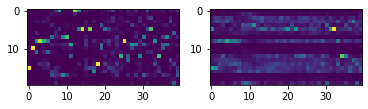

In [14]:
plt.subplot(1,2,1)
plt.imshow(Z[:20,:40].detach().cpu())
plt.subplot(1,2,2)
plt.imshow(F.softmax(F.softshrink(Zout[:20,:40]),dim=0).detach().cpu())

tensor(0.0033)

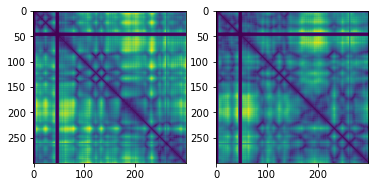

In [15]:
jj = 9
plt.subplot(1,2,1)
plt.imshow(MM[jj]*TrueD[jj])
plt.subplot(1,2,2)
plt.imshow(MM[jj]*RecD[jj])

torch.norm((TrueD[jj]-RecD[jj]))/TrueD[jj].shape[0]/(TrueD[jj].shape[1]-1)

tensor(0.3717)
tensor(0.3717)


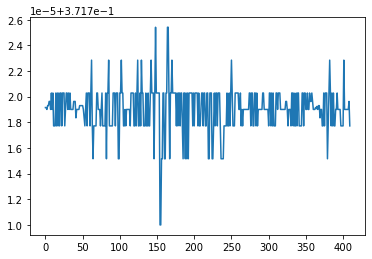

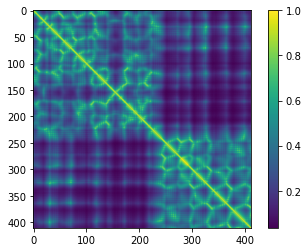

In [16]:
plt.imshow(Dt.cpu())
plt.colorbar()

In [14]:
Coords.device
tt = torch.zeros(3,3,device=Coords.device)

In [14]:
SVal     = torch.load('../data/casp11/PSSMVal.pt')

In [15]:
len(SVal)

224